# Data Analytics Final Project: 
*"Comparing Researchers teaching performance with faculty members dedicated completely to teaching"*

- Luis Ángel Sedas Díaz
- Mario Chávez

Tecnológico de Monterrey, Monterrey, NL, México

<p style="background-color:rgb(230,230,230);"> <b>Abstract:</b> University rankings have become a relevant factor that measures quality and performance. In those rankings, research activity is one of the most important metrics, and so universities need to motivate their faculty members to constantly contribute with new knowledge. It is common for researchers to also do lectures at different academic levels, apart from their research activity. The background and activities of a researcher are different from someone who is fully dedicated to teaching. For many years, there has been a debate between who usually develops better as a teacher, whether researchers or full-time professors. The current research aims to end with that discussion. The stated hypothesis is that researchers teaching performance is better than faculty members dedicated completely to teaching. The results of this analysis could be of significant relevance to academic institutes and could support the development of efficient research and learning strategies.</p>

## Contents
1. [Data Wrangling](DA-cleaning.ipynb) - Notebook for cleaning data
2. [Functions](functions.ipynb) - all created functions
3. [Descriptive Analysis](#descriptive_analysis)
    1. [Pie Charta](#pie_charts)
    2. [Score Distributions](#score_distributions)
4. [Graduate vs. Undergraduate](#under_grad)
    1. [chi2-test](#chi_test)
    2. [Clustering](#clustering)
    3. [Logistic regression](#logistic_regression)
    4. [Decision tree](#decision_tree)
- [Conclusions](#conclusions)


Questions and Tasks:
- What is the relation between research and teaching?
- What characteristics do researchers, who are qualified as good/bad, have in common?
- What characteristics do professors, who are qualified as good/bad, have in common?
- Create a classification variable (good or bad) for each professor, and so we need to generate a criteria of what is a good/bad score. We can start by partition around the median (50%).
- Find which variables affect the most the score in ECOA (feature selection).
- Apply clustering to find similarities between individuals.

<p style="background-color:yellow;"> We want to test if a category makes a significant difference in the scores distribution. With this we can generate a set of features later on in the clustering phase. We also need to research feature selection and the preprocessing package of scikitlearn to understand the best way to prepare the data.</p>

## 1. Data Cleaning
The data is an `.xlsx` file, with 15781 registers and 60 feautures, that describe the course, the professor and the evaluation of students.

In [41]:
%run .\DA-cleaning.ipynb

## 2. Functions

In [31]:
%run .\functions.ipynb

## 3. Descriptive Analysis<a id='descriptive_analysis'></a>
Here I try to understand how the data is distributed along the different features 

In [32]:
# Creates a table, grouping by 'Campus'
table_count_campus = data[['campus','ID']].groupby(['campus'],as_index=False).count().sort_values(by=['ID'],ascending=False).reset_index(drop=True)
table_count_campus['percentage'] = table_count_campus['ID']/len(data)*100

In [33]:
# Creates a new table, groping the last 24 campus as 'Others'
new_table_count_campus = table_count_campus[0:8].copy()

d = {'campus': ['Others'], 'ID': [table_count_campus[7:].ID.sum()], 'percentage': [table_count_campus[8:].ID.sum()/len(data)*100]}
df = pd.DataFrame(data=d)

new_table_count_campus = new_table_count_campus.append(df, ignore_index=True)

### 3.1 Pie Charts <a id ='pie_charts'></a>

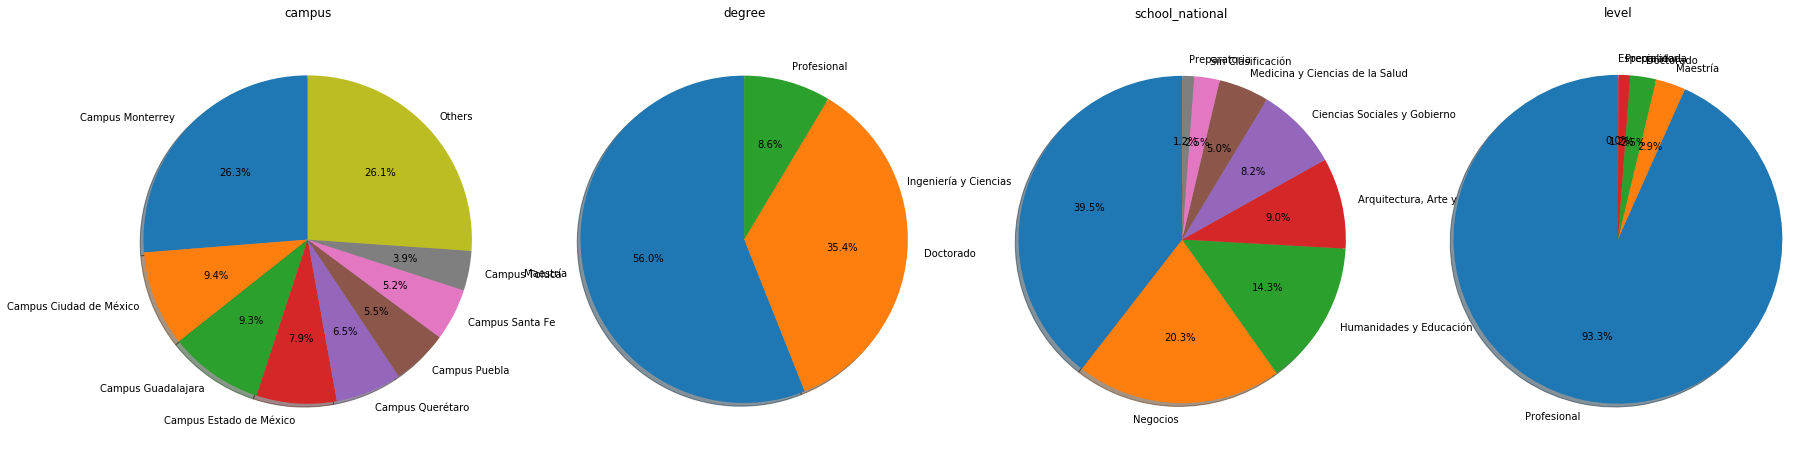

In [35]:
plt.figure(figsize=(30,8))       # set dimensions of the figure
plt.subplot(1,4, 1); pie_plot(new_table_count_campus,'campus','ID')
plt.subplot(1,4, 2); pie_plot(grouping_df(data,'degree','ID'),'degree','ID')
plt.subplot(1,4, 3); pie_plot(grouping_df(data,'school_national','ID'),'school_national','ID')
plt.subplot(1,4, 4); pie_plot(grouping_df(data,'level','ID'),'level','ID')
plt.show()

### 3.2 Score distributions<a id='score_distributions'></a>


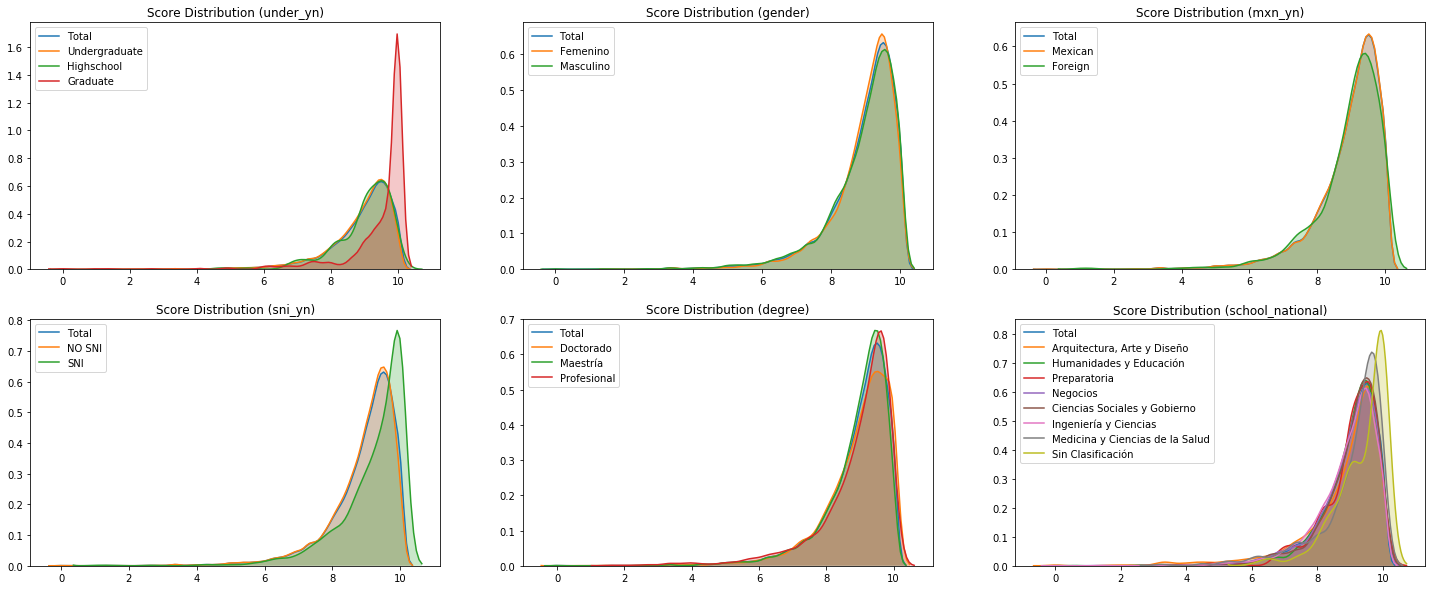

In [36]:
plt.figure(figsize=(25,10))       # set dimensions of the figure
plt.subplot(2,3, 1);     distribution_plot(data,'under_yn')
plt.subplot(2,3, 2);     distribution_plot(data,'gender')
plt.subplot(2,3, 3);     distribution_plot(data,'mxn_yn')
plt.subplot(2,3, 4);     distribution_plot(data,'sni_yn')
plt.subplot(2,3, 5);     distribution_plot(data,'degree')
plt.subplot(2,3, 6);     distribution_plot(data,'school_national')
plt.show()

We can see that Graduate students give better scores to their professors. Because 94% of the data is from undergraduate courses, this distribution is basically the same as the one from the complete data. This also happens in the distribution of "NO SNI" which are the no reseachers, because this represents the 90% of the individuals.

From these plots we can se that the distributions that differ from the rest are the ones of:
- **under_yn**
- **sni_yn**

In [37]:
prueba_pivot = pd.pivot_table(data, values='ID', index=['sni_yn'], columns=['under_yn'], aggfunc=len, margins=True)
(prueba_pivot/15781*100).round(decimals=2)

under_yn,Graduate,Highschool,Undergraduate,All
sni_yn,,,,
NO SNI,1.30,1.12,87.87,90.29
SNI,4.22,0.04,5.44,9.71
All,5.52,1.17,93.31,100.00


From this pivot table we can see different things:
1. Not researchers (NO_SNI) give classes maninly on the Undergraduate level (97.3%)
2. Researchers give (SNI) are divided pretty equally on Undergraduate and Graduate courses (56.02% & 43.4%)

We are going to analyze how researchers and non-researchers behave in:
- General (Along all courses).
- by course level.
- by subject area.

### 3.3 Experience vs Score  <a id='under_grad'></a>

In [38]:
df_under = data[data.under_yn == 'Undergraduate'].reset_index(drop=True)
df_grad = data[data.under_yn == 'Graduate'].reset_index(drop=True)

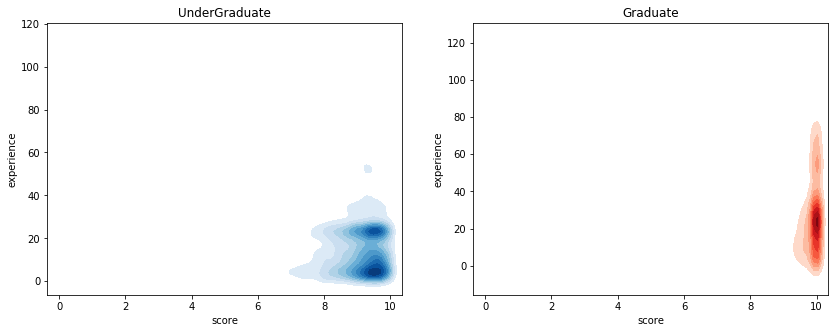

In [94]:
plt.figure(figsize=(14,5))       # set dimensions of the figure
plt.subplot(1,2, 1); 
sns.kdeplot(df_under[['score','experience']].dropna().score, df_under[['score','experience']].dropna().experience,cmap="Blues", shade=True, shade_lowest=False)
plt.title('UnderGraduate')
plt.subplot(1,2, 2); 
sns.kdeplot(df_grad[['score','experience']].dropna().score, df_grad[['score','experience']].dropna().experience,cmap="Reds", shade=True, shade_lowest=False)
plt.title('Graduate')
plt.show()

From the Graduate Jointplot we can see that the scores are concentrated and the experience is really spread, so at the graduate level the professors get the same score, but their experience varies a lot. While in the undergraduate case both are relatively spread, bu the experience variable has a bimodal distribution. 


## 4. Selecting Variables

In [57]:
data.columns

Index(['Crn', 'ID', 'rectoria', 'campus', 'division', 'department', 'thesis',
       'num_grup', 'cat_lab', 'cat_escolar', 'cat_rh', 'nationality', 'gender',
       'age', 'antiguedad', 'degree', 'pdhd', 'experience', 'school_national',
       'school_giee', 'giee', 'giee_role', 'SNI', 'percentage_responsability',
       'level', 'terminal_group', 'course_attributes', 'multicampus',
       'main_professor', 'seniors', 'opinions', 'participation', 'teach_hours',
       'lecture_hours', 'lab_hours', 'credits', '05num', '05avg', '05std',
       '06num', '06avg', '06std', '08num', '08avg', '08std', 'books',
       'bseries', 'proceedings', 'journal_q1q2', 'journal_q3q4', 'total',
       'books_norm', 'bseries_norm', 'proceedings_norm', 'journal_q1q2_norm',
       'journal_q1q2_norm', 'total_norm', 'sni_yn', 'score', 'under_yn',
       'mxn_yn'],
      dtype='object')

In [60]:
data_prep = data[['thesis','age', 'antiguedad','experience','percentage_responsability','terminal_group','multicampus','main_professor','seniors','participation','teach_hours',
                  'lecture_hours', 'lab_hours','credits','total_norm', 'sni_yn', 'score','under_yn', 'mxn_yn']];
df_dum = pd.get_dummies(data_prep);

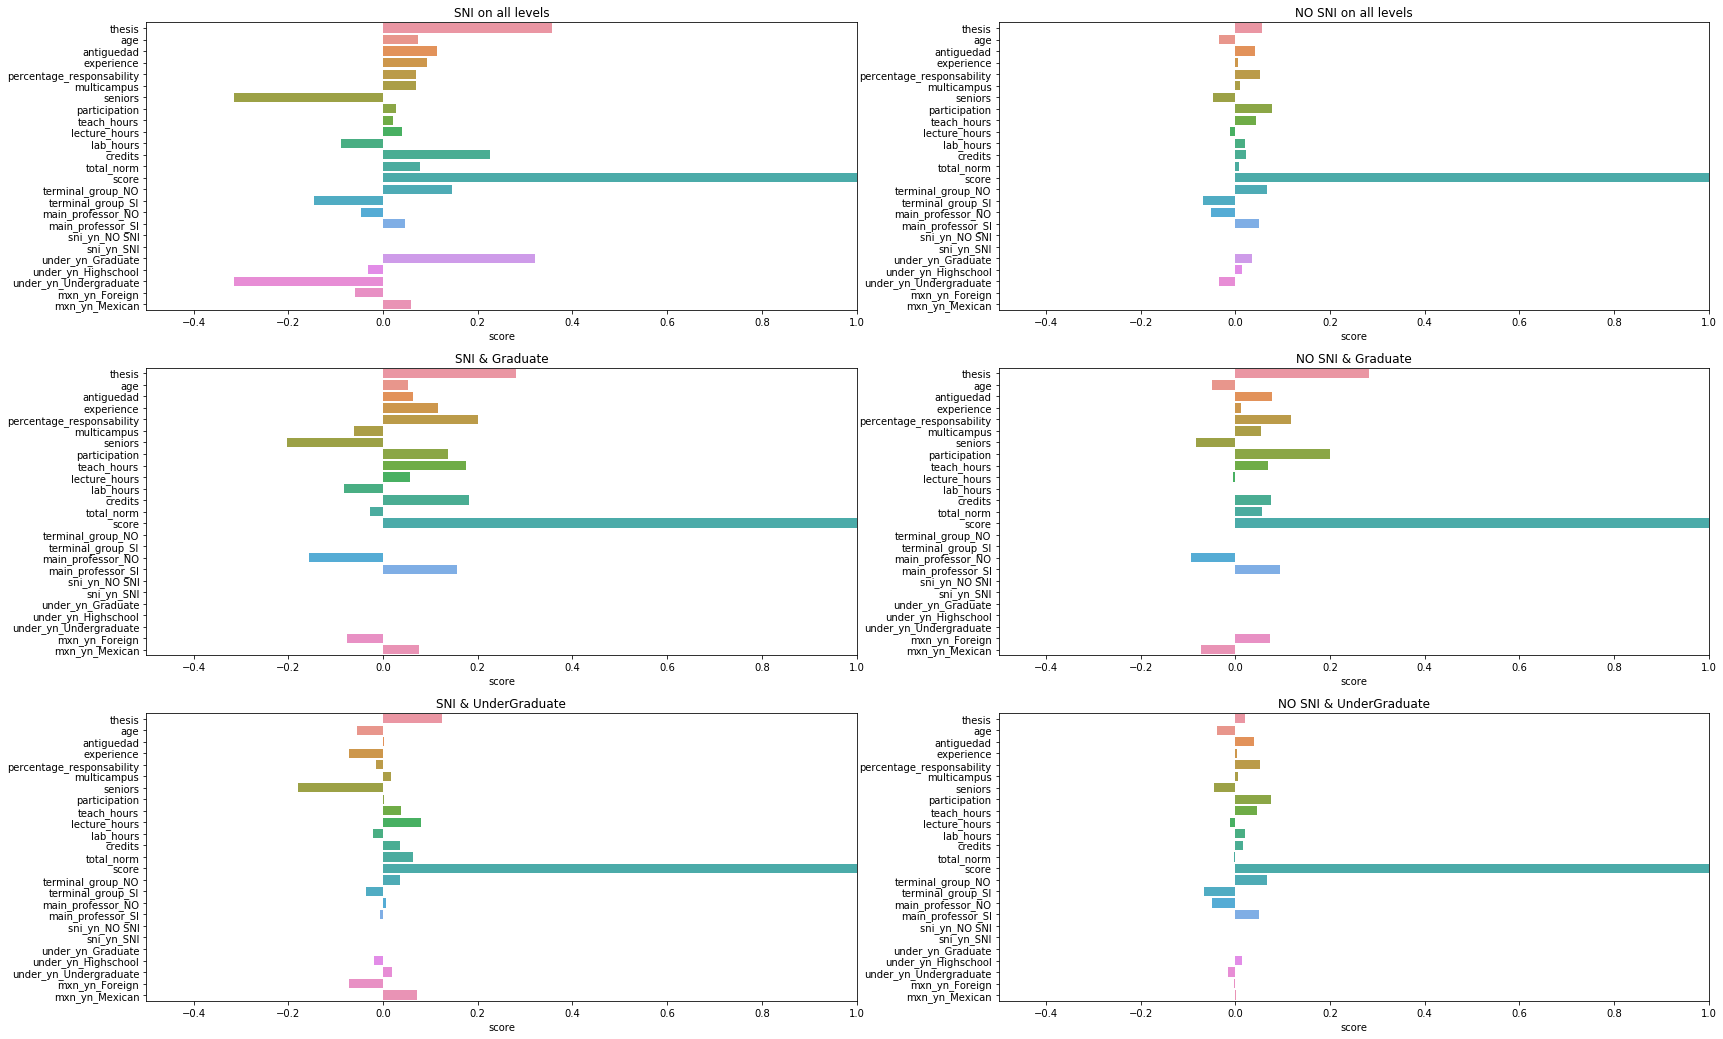

In [102]:
plt.figure(figsize=(28,18))       # set dimensions of the figure

plt.subplot(3,2, 1); 
corr = df_dum[df_dum.sni_yn_SNI==1].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI on all levels')

plt.subplot(3,2, 2); 
corr = df_dum[df_dum.sni_yn_SNI==0].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI on all levels')

plt.subplot(3,2, 3); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==1,df_dum.under_yn_Graduate==1)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI & Graduate')

plt.subplot(3,2, 4); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==0,df_dum.under_yn_Graduate==1)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI & Graduate')

plt.subplot(3,2, 5); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==1,df_dum.under_yn_Graduate==0)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('SNI & UnderGraduate')

plt.subplot(3,2, 6); 
corr = df_dum[np.logical_and(df_dum.sni_yn_SNI==0,df_dum.under_yn_Graduate==0)].corr();
y_index = corr.index;
values_cor = corr['score'];
sns.barplot(y = y_index, x = values_cor, orient='h');plt.xlim((-0.5,1));plt.title('NO SNI & UnderGraduate')

plt.show()

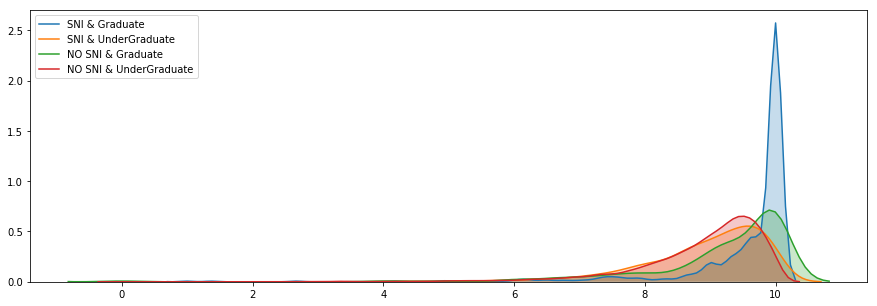

In [67]:
plt.figure(figsize=(15,5))
sns.kdeplot(data[np.logical_and(data.sni_yn=='SNI',data.under_yn=='Graduate')].score, label = 'SNI & Graduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='SNI',data.under_yn=='Undergraduate')].score, label = 'SNI & UnderGraduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='NO SNI',data.under_yn=='Graduate')].score, label = 'NO SNI & Graduate', shade=True)
sns.kdeplot(data[np.logical_and(data.sni_yn=='NO SNI',data.under_yn=='Undergraduate')].score, label = 'NO SNI & UnderGraduate', shade=True)
plt.show()

In [ ]:
values = {'age': df_dum.age.mean(), 'antiguedad': df_dum.aantiguedad.mean(), 'C': 2, 'D': 3}
df_dum.fillna(value=values)

In [112]:
for i in df_dum:
    print(i,sum((df_dum[i].isnull())*1))

thesis 0
age 5284
antiguedad 2136
experience 1274
percentage_responsability 0
multicampus 0
seniors 1
participation 1
teach_hours 0
lecture_hours 0
lab_hours 0
credits 0
total_norm 0
score 73
terminal_group_NO 0
terminal_group_SI 0
main_professor_NO 0
main_professor_SI 0
sni_yn_NO SNI 0
sni_yn_SNI 0
under_yn_Graduate 0
under_yn_Highschool 0
under_yn_Undergraduate 0
mxn_yn_Foreign 0
mxn_yn_Mexican 0


We can see that a lot of variables have nana values, so we need to drop the variables that have most nan values, and then remove nan values

In [136]:
# Drop variables with a lot of nan, and then replace nan with mean
df_dum = df_dum.drop(['age','antiguedad'],axis=1).fillna({'experience': df_dum.experience.mean(),'score':df_dum.score.mean()}).dropna()

## 5. Clustering

In [140]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

In [144]:
silhouettes = []
inertias = []
calinski = []

for i in range(2,13):
    kmeans = KMeans(n_clusters=i).fit(df_dum)
    labels = kmeans.labels_
    sil = metrics.silhouette_score(df_dum, labels, metric='euclidean')
    cal = metrics.calinski_harabaz_score(df_dum, labels)
    ine = kmeans.inertia_
  
    silhouettes.append(sil)
    inertias.append(ine)    
    calinski.append(cal)

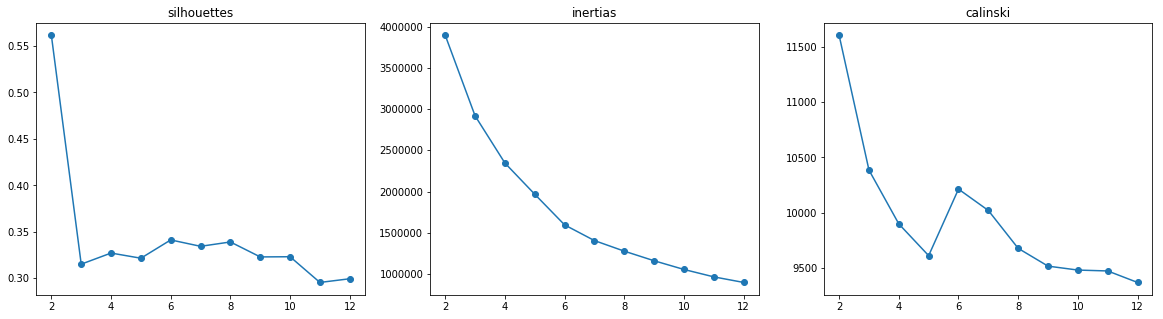

In [159]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1); plt.plot([2,3,4,5,6,7,8,9,10,11,12], silhouettes, '-o'); plt.title('silhouettes')
plt.subplot(1,3,2); plt.plot([2,3,4,5,6,7,8,9,10,11,12], inertias, '-o'); plt.title('inertias')
plt.subplot(1,3,3); plt.plot([2,3,4,5,6,7,8,9,10,11,12], calinski, '-o'); plt.title('calinski')
plt.show()

## 6. Classification

### 4.1 $\chi^2-$test <a id='chi_test'></a>
A chi-squared test, also written as χ2 test, is any statistical hypothesis test where the sampling distribution of the test statistic is a chi-squared distribution when the null hypothesis is true. Without other qualification, 'chi-squared test' often is used as short for Pearson's chi-squared test. The chi-squared test is used to determine whether there is a significant difference between the expected frequencies and the observed frequencies in one or more categories.

In [116]:
from scipy.stats import chisquare

### 4.2 Clustering <a id='clustering'></a>
The first thing we need is to determine which variables are we going to use. We have three variables that measure time:

- The variable `age` has 5284 blanks, which is more than one third of the data. We cannot use this feature.

- The variable `Años de Antigüedad` has 2136 blanks.

- The variable `experience` has 1274 blanks.

For this first test we will use the variables:
- experience
- sni_yn
- under_yn

to predict

- score_category

In [576]:
data_temp = data.copy()
data_temp = data_temp.dropna(subset=['score'])
#We create a classification variable for the performance of a professor, separating in two DF's
cond1 = (data_temp.score >= data_temp.score.quantile(0.75)).replace([True,False],['good',''])
cond2 = (np.logical_and(data_temp.score < data_temp.score.quantile(0.75),data_temp.score > data_temp.score.quantile(0.25))).replace([True,False],['regular',''])
cond3 = (data_temp.score <= data_temp.score.quantile(0.25)).replace([True,False],['bad',''])
data_temp['score_category'] = (cond1+cond2+cond3)

In [593]:
data_mty = data[data.Campus =='Campus Monterrey'];
data_mty = data_mty.dropna(subset=['score'])
cond1 = (data_mty.score >= data_mty.score.quantile(0.75)).replace([True,False],['good',''])
cond2 = (np.logical_and(data_mty.score < data_mty.score.quantile(0.75),data_mty.score > data_mty.score.quantile(0.25))).replace([True,False],['regular',''])
cond3 = (data_mty.score <= data_mty.score.quantile(0.25)).replace([True,False],['bad',''])
data_mty['score_category'] = (cond1+cond2+cond3)

In [409]:
#We create a classification variable for the performance of a professor, separating in two DF's
cond1 = (df_under.score >= df_under.score.quantile(0.75)).replace([True,False],['good',''])
cond2 = (np.logical_and(df_under.score < df_under.score.quantile(0.75),df_under.score > df_under.score.quantile(0.25))).replace([True,False],['regular',''])
cond3 = (df_under.score <= df_under.score.quantile(0.25)).replace([True,False],['bad',''])
df_under['score_category'] = (cond1+cond2+cond3)

In [443]:
#We create a classification variable for the performance of a professor, separating in two DF's
cond1 = (df_grad.score >= df_grad.score.quantile(0.75)).replace([True,False],['good',''])
cond2 = (np.logical_and(df_grad.score < df_grad.score.quantile(0.75),df_grad.score > df_grad.score.quantile(0.25))).replace([True,False],['regular',''])
cond3 = (df_grad.score <= df_grad.score.quantile(0.25)).replace([True,False],['bad',''])
df_grad['score_category'] = (cond1+cond2+cond3)
df_grad = df_grad[df_grad.score_category != '']

### 4.3 Logistic regression <a id='logistic_regression'></a>

1. **<span style="color:green">✓</span>** Binary logistic regression requires the dependent variable to be binary. 
2. **<span style="color:green">✓</span>** For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
3. Only the meaningful variables should be included.
4. The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
5. The independent variables are linearly related to the log odds.
6. Logistic regression requires quite large sample sizes.

In [406]:
#from sklearn.linear_model import LogisticRegression
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

### 4.4 Decision Tree <a id='decision_tree'></a>
Pros
- Decision trees are easy to interpret and visualize.
- It can easily capture Non-linear patterns.
- It requires fewer data preprocessing from the user, for example, there is no need to normalize columns.
- It can be used for feature engineering such as predicting missing values, suitable for variable selection.
- The decision tree has no assumptions about distribution because of the non-parametric nature of the algorithm. (Source)

Cons
- Sensitive to noisy data. It can overfit noisy data.
- The small variation(or variance) in data can result in the different decision tree. This can be reduced by bagging and boosting algorithms.
- Decision trees are biased with imbalance dataset, so it is recommended that balance out the dataset before creating the decision tree.


In [531]:
#https://www.datacamp.com/community/tutorials/decision-tree-classification-python
#https://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

#### Graduate <a id='decision_tree_grad'></a>

In [532]:
df_grad_temp = df_grad[['score_category','sni_yn','under_yn','experience','grado']].dropna()
df_grad_temp_X = df_grad_temp.drop('score_category',axis=1)
df_grad_temp_y = df_grad_temp.score_category

# Encodes catagerical data
enc = preprocessing.OrdinalEncoder()
X = df_grad_temp_X.values
enc.fit(X)
X_encoded = enc.transform(df_grad_temp_X.values);

le = preprocessing.LabelEncoder()
le.fit(np.ndarray.tolist(df_grad_temp_y.unique()))
y_encoded = le.transform(df_grad_temp_y);

#Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.33, random_state=42)

In [533]:
# Trains the tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [535]:
#Testing state
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5802469135802469


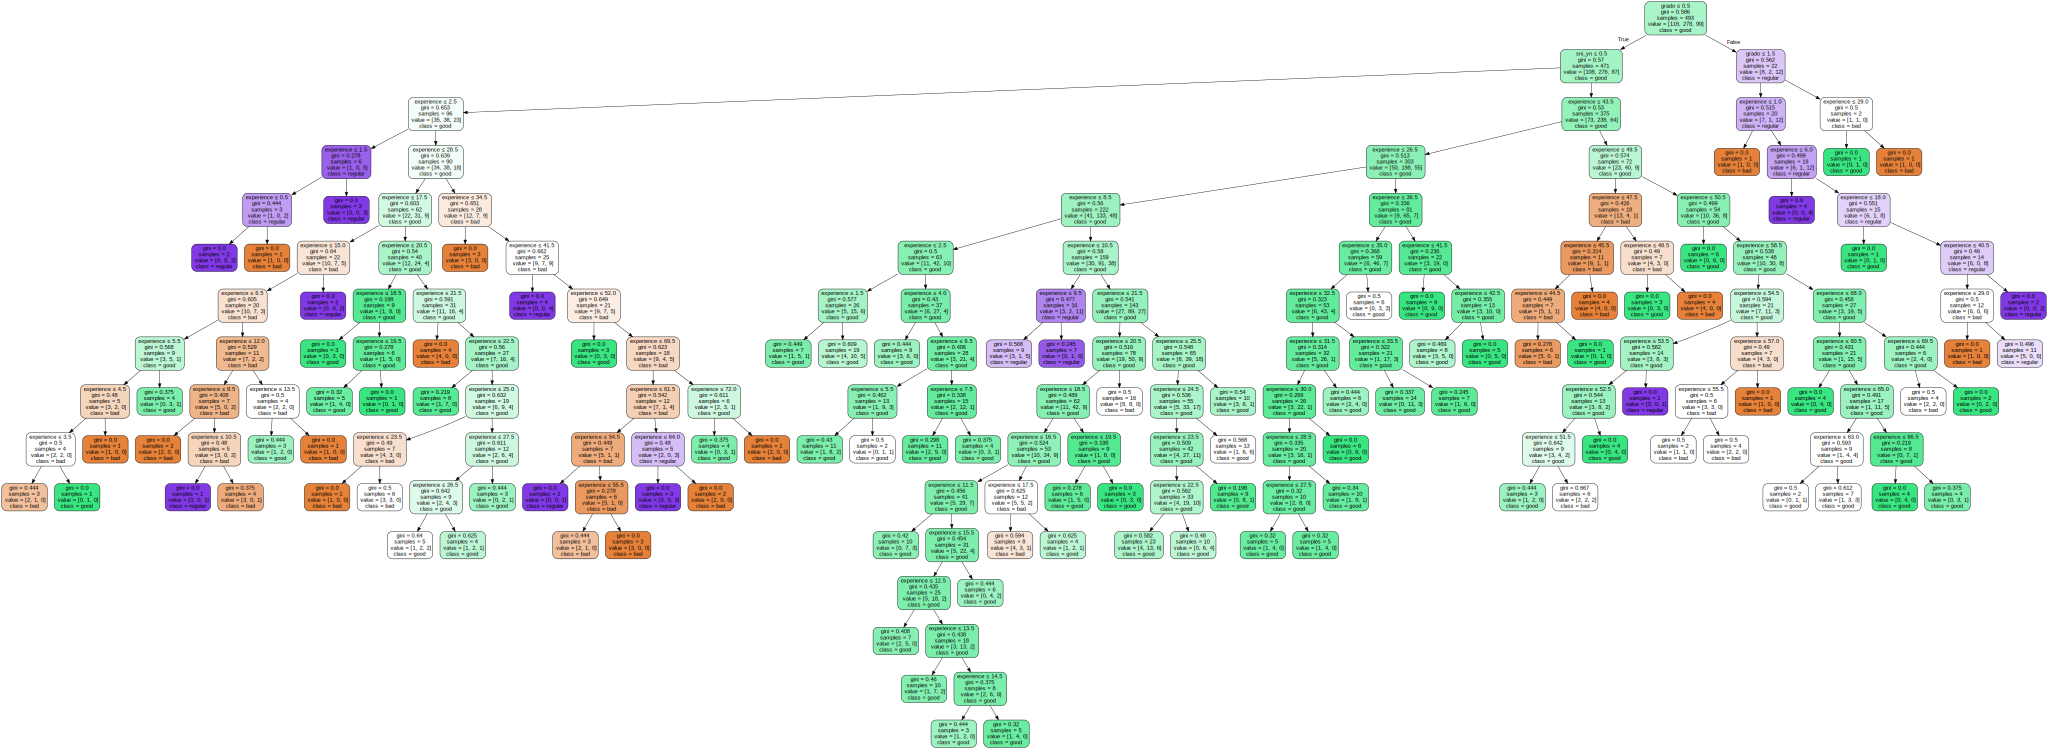

In [534]:
#Draws the decision tree
import graphviz 
dot_data = tree.export_graphviz(clf,
                                out_file=None,
                                feature_names = np.ndarray.tolist(df_grad_temp_X.columns.values),
                                class_names = df_grad_temp_y.unique(),
                                filled=True,
                                rounded=True,
                                special_characters=True)  
graph = graphviz.Source(dot_data)  
#graph.render('tree_grad')

#### Undergraduate <a id='decision_tree_under'></a>

In [536]:
df_under_temp = df_under[['score_category','sni_yn','under_yn','experience','grado']].dropna()
df_under_temp_X = df_under_temp.drop('score_category',axis=1)
df_under_temp_y = df_under_temp.score_category

# Encodes catagerical data
enc = preprocessing.OrdinalEncoder()
X = df_under_temp_X.values
enc.fit(X)
X_encoded = enc.transform(df_under_temp_X.values);

le = preprocessing.LabelEncoder()
le.fit(np.ndarray.tolist(df_under_temp_y.unique()))
y_encoded = le.transform(df_under_temp_y);

#Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.33, random_state=42)

In [537]:
# Trains the tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [538]:
#Testing state
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.478659217877095


#### Total

In [578]:
data_temp2 = data_temp[['score_category','sni_yn','under_yn','experience','grado']].dropna()
data_temp2_X = data_temp2.drop('score_category',axis=1)
data_temp2_y = data_temp2.score_category

# Encodes catagerical data
enc = preprocessing.OrdinalEncoder()
X = data_temp2_X.values
enc.fit(X)
X_encoded = enc.transform(data_temp2_X.values);

le = preprocessing.LabelEncoder()
le.fit(np.ndarray.tolist(data_temp2_y.unique()))
y_encoded = le.transform(data_temp2_y);

#Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.33, random_state=42)

In [579]:
# Trains the tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [580]:
#Testing state
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5006297229219143


#### Campus Mty

In [594]:
df_mty_temp = data_mty[['score_category','sni_yn','under_yn','experience','grado']].dropna()
df_mty_temp_X = df_mty_temp.drop('score_category',axis=1)
df_mty_temp_y = df_mty_temp.score_category

# Encodes catagerical data
enc = preprocessing.OrdinalEncoder()
X = df_mty_temp_X.values
enc.fit(X)
X_encoded = enc.transform(df_mty_temp_X.values);

le = preprocessing.LabelEncoder()
le.fit(np.ndarray.tolist(df_mty_temp_y.unique()))
y_encoded = le.transform(df_mty_temp_y);

#Splits the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.33, random_state=42)

In [595]:
# Trains the tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [596]:
#Testing state
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4876543209876543


## Conclusions <a id='conclusions'></a>

In [ ]:
# Preguntas
- Qué es bueno? quartiles?
- Error en %Participación, >100% y por lo tanto tambien está mal Alumnos que Opinaron
- Semestres de Experiencia tiene un máximo de 114 
- Mejor variable de experiencia? Semestres de experiencia, edad al semestre, años de antiguedad